## CNN for GTZAN

In [6]:
# Python and usual libraries
import os
import sys
import keras
import librosa
import argparse
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

# Keras imports
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization

### Define the class with Melspectrogram

In [7]:
class MelSpectrogram(object):
    def __init__(self, file_path):
        # Constants
        self.song_samples = 660000
        self.n_fft = 2048
        self.hop_length = 512
        self.tol = 10e-3
        self.file_path = file_path
        self.genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4,
            'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
  
    def getdata(self):
        # Structure for the array of songs
        song_data = []
        genre_data = []
        
        print("::: START READING AUDIO FILES")
        # Read files from the folders
        for x,_ in self.genres.items():
            for root, subdirs, files in os.walk(self.file_path + x):
                for file in files:
                    # Read the audio file
                    file_name = self.file_path + x + "/" + file
                    signal, sr = librosa.load(file_name)
          
                    # Calculate the melspectrogram of the audio and use log scale
                    melspec = librosa.feature.melspectrogram(signal[:self.song_samples],
                    sr = sr, n_fft = self.n_fft, hop_length = self.hop_length)
          
                    # Append the result to the data structure
                    song_data.append(melspec.T)
                    genre_data.append(self.genres[x])
        print("::: FINISHED READING AUDIO FILES")
        return np.array(song_data), keras.utils.to_categorical(genre_data, len(self.genres))
    
    def normalize(self, songs):
        # Allocate memory
        norm_songs = np.zeros(songs.shape)
        for i in range(songs.shape[0]):
            # Subtrac the mean
            song_mean_channel = list(map(lambda x, y: x - y, songs[i], np.mean(songs[i], axis=1)))
            song_mean_channel = np.array(song_mean_channel)
        
            # Get the std of each channel
            song_std = np.std(songs[i], axis=1)
            song_std[song_std <= self.tol] = 1
        
            # Division by the std
            song_norm_channel = list(map(lambda x, y: x/y, song_mean_channel, song_std))
            song_norm_channel = np.array(song_norm_channel)
        
            # Save normalized spectrograms
            norm_songs[i] = song_norm_channel
        return norm_songs
    
    def logscale(self, songs):
        # Allocate memory
        logscale_songs = np.zeros(songs.shape)
        for i in range(songs.shape[0]):
            logscale_songs[i] = librosa.logamplitude(songs[i])
        return logscale_songs

### Read the data

In [8]:
# Disable TF warnings about speed up
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Constants
GTZAN_FOLDER = '../dataset/GTZAN/'

# Create a MFCC representation from the GTZAN Dataset
song_rep = MelSpectrogram(GTZAN_FOLDER)
input_shape = (1290, 128)

songs, genres = song_rep.getdata()
print(songs.shape)
print(genres.shape)

::: START READING AUDIO FILES
::: FINISHED READING AUDIO FILES
(1000, 1290, 128)
(1000, 10)


In [9]:
song_norm = song_rep.normalize(songs)

In [11]:
songs = None

### Music Information Retrieval (MIR) Basics

#### Spectrogram Visualization

In [12]:
# Module to "visualize" the song in Jupyter notebook
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt

##### Analyse a Reggae song

In [13]:
# Load a reggae song
x, fs = librosa.load('../dataset/GTZAN/reggae/reggae.00015.au')
ipd.Audio(x, rate=fs)

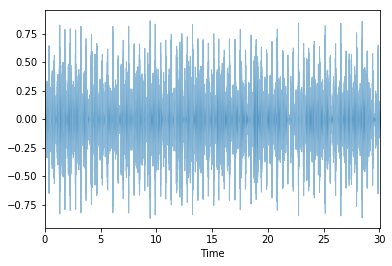

In [14]:
# Plot the wave form
plt.figure()
librosa.display.waveplot(x, fs, alpha=0.5)
plt.show()

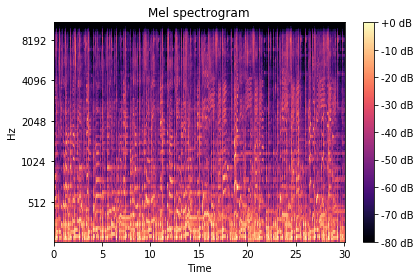

In [15]:
# Show the melspectrogram in log scale
plt.figure()
S = librosa.feature.melspectrogram(x, sr=fs, n_fft=2048, hop_length = 512)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
    y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

##### Analyse a Metal song

In [16]:
# Load a metal song
y, fs = librosa.load('../dataset/GTZAN/metal/metal.00015.au')
ipd.Audio(y, rate=fs)

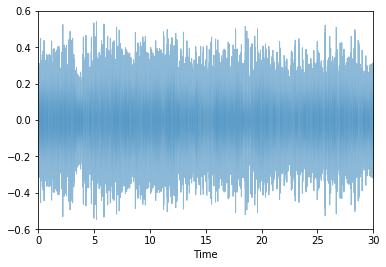

In [17]:
# Plot the wave form
plt.figure()
librosa.display.waveplot(y, fs, alpha=0.5)
plt.show()

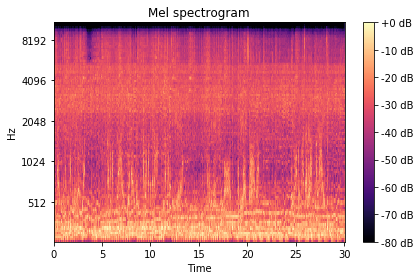

In [18]:
# Show the melspectrogram in log scale
plt.figure()
S = librosa.feature.melspectrogram(y, sr=fs, n_fft=2048, hop_length = 512)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
    y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

### Define the architecture of the CNN

In [25]:
def cnn_gtzan_model(input_shape):
    model = Sequential()
  
    # First Conv Layer
    model.add(Conv1D(256,
        kernel_size = 4,
        activation='relu',
        input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4, strides=4))
  
    # Second Conv Layer
    model.add(Conv1D(512, 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())

    # Regular MLP
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    return model

### Train the Network

In [26]:
# Constants
batch_size = 64
epochs = 30

# song_input
#song_input = songs
#song_input = song_logscale
song_input = song_norm


# Split the dataset into training and test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
for train_index, test_index in sss.split(song_input, genres):
    x_train, x_test = song_input[train_index], song_input[test_index]
    y_train, y_test = genres[train_index], genres[test_index]

# Construct the model
cnn = cnn_gtzan_model(input_shape)
print("Size of the CNN: %s" % cnn.count_params())

sgd = keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-6, nesterov=True)
cnn.compile(loss=keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

cnn.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))

score = cnn.evaluate(x_test, y_test, verbose=0)
    
# Print the confusion matrix of the model
pred_values = np.argmax(cnn.predict(x_test), axis = 1)
cm = confusion_matrix(np.argmax(y_test, axis = 1), pred_values)
print(cm)

# Print metrics
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Size of the CNN: 1194762
Train on 700 samples, validate on 300 samples
Epoch 1/30
700/700 [==============================] - 104s - loss: 2.3605 - acc: 0.3600 - val_loss: 2.2583 - val_acc: 0.1833
Epoch 2/30
700/700 [==============================] - 41s - loss: 1.1666 - acc: 0.6043 - val_loss: 2.2243 - val_acc: 0.2033
Epoch 3/30
700/700 [==============================] - 41s - loss: 0.6551 - acc: 0.7886 - val_loss: 2.1846 - val_acc: 0.2200
Epoch 4/30
700/700 [==============================] - 44s - loss: 0.3481 - acc: 0.9029 - val_loss: 2.1549 - val_acc: 0.2400
Epoch 5/30
700/700 [==============================] - 45s - loss: 0.2130 - acc: 0.9443 - val_loss: 2.1214 - val_acc: 0.3067
Epoch 6/30
700/700 [==============================] - 46s - loss: 0.1445 - acc: 0.9714 - val_loss: 2.0869 - val_acc: 0.4300
Epoch 7/30
700/700 [==============================] - 46s - loss: 0.0897 - acc: 0.9857 - val_loss: 2.0594 - val_acc: 0.6033
Epoch 8/30
700/700 [==============================] - 45s - 